In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import csv
from scipy import stats
from itertools import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,f_classif,SelectPercentile
from sklearn.linear_model import Lasso,lasso_path,LassoCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from scipy.stats import sem
from pandas import Series,DataFrame
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.externals import joblib
%matplotlib inline
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
plt.show()

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#函数功能：输入路径和分类名，返回训练矩阵
def read_file(path):
    df = pd.read_csv(path,index_col=0,encoding='gbk')   
#   new_df = new_df.replace(u'是',u'0')

    
# 根据某一列进行数据分组   
#     grouped = new_df.groupby('label')
#     uniquekeys=[]
#     data = []
#     for k,g in grouped:
#         groups=list(g)
#         uniquekeys=k
#         print (uniquekeys) #打印分组组别
#     data = grouped.get_group(groupid)
#   data.to_csv("C://qing1//data_voi_1.csv")   #分组数据的输出

    X = df.iloc[:,1:]#1开始计数，－2
    y = df.iloc[:,0]  #1开始计数，－2
    
    #ss = StandardScaler().fit(X)
    #X_std = ss.transform(X)  #为了数据归一化（使特征数据方差为1，均值为0）
    #X = DataFrame(X_std,index=X.index,columns=X.columns)
    
    features = [X.columns]
    
    print (len(X))  #打印X行数
    print (len(y))  #打印y行数
    print (features[0]) #打印X的列名，确认第一个列名是否正确
    print (y.describe()) #打印Y的信息，确认Y是否正确
    return X,y,features

In [20]:
#函数功能：按照比例随机分组，标准化，正则化
def train_test(X,y,random):
    grouped = y.groupby(y)
    uniquekeys=[]
    data = []
    for k,g in grouped:
        groups=list(g)
        uniquekeys=k
    y0 = grouped.get_group(0)
    y1 = grouped.get_group(1)
    X0 = DataFrame(X,index=y0.index)
    X1 = DataFrame(X,index=y1.index)
    
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=.2,random_state=random)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.2,random_state=random)
    
    X_train = pd.concat([X_train0,X_train1],axis=0,join='inner')
    X_test = pd.concat([X_test0,X_test1],axis=0,join='inner')
    y_train = pd.concat([y_train0,y_train1],axis=0,join='inner')
    y_test = pd.concat([y_test0,y_test1],axis=0,join='inner')

    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    
    ss = StandardScaler().fit(X_train)
    X_train_std = ss.transform(X_train)
    X_train = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)
    X_test = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    return X_train,y_train,X_test,y_test

In [21]:
def move_lowvariance(X,y):
    sel = VarianceThreshold(threshold=(.08 * (1 - .08)))
    sel_X = sel.fit_transform(X)
    result = sel.get_support()
    features = X.columns
    features_split = []
    sel_features = []
    sel_features_split = []
    first = []
    sel_first = []
    for index, item in enumerate(features):
        item_split = item.split('_')
        features_split.append(item_split)
        first.append(item_split[0])    
        if result[index]:
            sel_features.append(item)
            sel_features_split.append(item_split)
            sel_first.append(item_split[0])
    print(("features reduced from {0} to {1}".format(len(features),len(sel_features))))
    X = X[sel_features]
    y = y
    features = sel_features
    return X,y,features

In [22]:
# 功能：输入特征矩阵和因变量，输出筛选后的特征矩阵，因变量，筛选的特征名称
def select_KBest(X,y):
    sel = SelectKBest(f_classif,k = 'all').fit(X,y)
    scores = sel.scores_
    pvalue = sel.pvalues_
    features = X.columns
    result = sel.get_support()
    sort_features = []
    for index, item in enumerate(features):
        if result[index]:
            sort_features.append(item)
    named_scores = zip(features, scores, pvalue) 
    sel_scores = list(filter(lambda row: row[2] < 0.05, named_scores))#筛选特征
    sorted_scores = sorted(sel_scores,key = lambda z:z[1],reverse=True) 
    name=['name','scores','pvalue']
    sel_k=pd.DataFrame(columns=name,data=sorted_scores)#数据有三列，列名分别为
    num=len(sel_k)
    print(num)
    sel_k.to_csv(in_path+'sel_k.csv',encoding='gbk')#储存筛选的特征
    X = X[sel_k['name']]
    y =y
    print(("features reduced from {0} to {1}".format(len(features),num)))
    return X,y,sel_features

In [50]:
def lasso_filter(X,y,cv):   
    model = LassoCV(cv=cv,max_iter=3000).fit(X,y)
    w0=model.intercept_
    selected =  -np.log10(model.alpha_)
    m_log_alphas = -np.log10(model.alphas_)
    features = X.columns
    coef = pd.Series(model.coef_, index = features)
    sel_coef = coef[coef!=0]  
    sel_features = sel_coef.index
    X = X[sel_features]    
    
    
#     打印最佳alpha值  
    print(("features reduced from {0} to {1}".format(len(features),len(sel_features))))
    print("最佳alpha值为%.5f，-log10(alpha)为%.5f"%((model.alpha_,selected)))          
    print("截距=",w0)   
# 均方误差路径图
    plt.figure()
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.savefig(in_path+"Mean square error.png")
    plt.show() 
   
    eps = 1e-2 # the smaller it is the longer is the path alpha_min / alpha_max = 1e-2
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)
    plt.figure()
    ax = plt.gca()
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    for coef_l, c in zip(coefs_lasso,colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso Path')
    plt.axis('tight')
    plt.savefig(in_path+"Lasso Path.png")
    plt.show()
    
#     特征柱状图
    mp_coef = pd.concat([sel_coef.sort_values()])
    mp_coef.plot(kind = "barh",color='b')
    plt.yticks(fontsize=3)
    plt.title("Coefficients in the Lasso Model")
    plt.subplots_adjust(left=0.25)
    plt.savefig(in_path+"Coefficients in the Lasso Model.png")
#    表格导出
    X.to_csv(in_path+'lasso.csv')
    mp_coef.to_csv(in_path+'lasso-coef.csv')      
    return X,y,sel_features    

In [51]:
def matrix_report(y_test,y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    TN = matrix[1,1]
    TP = matrix[0,0]
    FN = matrix[0,1]
    FP = matrix[1,0]
    sensitivity = TP/float(FN+TP)
    specificity = TN/float(TN+FP)
    precision =  (TP+TN)/float(TN+FN+TP+FP)
    print (matrix)
    print('sensitivity = ',sensitivity) 
    print( 'specificity = ',specificity)
    print( 'precision = ',precision)

In [52]:
# 输入：真实值（0/1），预测值（0/1），预测概率；输出：ROC曲线、最佳阈值、AUC和95%CI、方差
def auc_report(y_test,y_pred,y_pred_prob):
#     选择阳性的标签（0/1）
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob, pos_label=1)
    auc_result = roc_auc_score(y_test, y_pred_prob)
    
#     cut-off point 
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i),'yd' : pd.Series(tpr-fpr, index=i), 'threshold' : pd.Series(thresholds, index=i)})
#     方法1：youdeng指数
#     roc_t = roc.ix[(-roc.yd).argsort()[:1]]   
#     方法2：(tpr-(1-fpr)指数
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    
    threshold_value = roc_t['threshold'].values
    
    #     figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot(fpr, tpr, color='b',label='area under AUC is {:0.2f}'.format(auc_result))
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    #plt.title('ROC curve for T2 classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    
#     输出最佳阈值、AUC和95%CI、方差
    print('tpr-(1-fpr)指数：threshold_value = ',threshold_value) 
    print ('auc = ',auc_result)

In [53]:
 def CI_ROC (y_true,y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true, dtype = int)
    n_bootstraps = 1000
    rng_seed = 42 
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    CI_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    CI_upper = sorted_scores[int(0.95 * len(sorted_scores))] 
    SD = np.std(sorted_scores)
    print (" 95%CI: [{:0.2f} - {:0.2f}]".format(CI_lower,CI_upper))
    print ('SD = ',SD)
    return CI_lower, CI_upper

In [54]:
import copy

def model_training(X,y,clf,cv):

    X_index = X.index
    X_index = DataFrame(X_index,columns=['X_index'])
    X = np.array(X) 
    yprob = DataFrame()

    cv = StratifiedKFold(n_splits=cv)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    
    clfs = []
    
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        pred_ = clf.fit(X[train], y[train]).predict(X[test])
        
        clfs.append(copy.deepcopy(clf))
        
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        matrix = confusion_matrix(y[test],pred_)
        print ('第 %d 折  matrix result:'%i)
        print (matrix)
        yprobabi = DataFrame(probas_,index = test, columns = ['y_proba0','y_proba1'])
        y_true = DataFrame(y[test],index = test,columns = ['y_true'])
        y_pred = DataFrame(pred_,index = test,columns = ['y_pred'])
        
        yprobabi = pd.concat([y_true,y_pred,yprobabi],axis=1,join='inner',ignore_index = False)
        yprob = yprob.append(yprobabi)
        y_proba = yprob.sort_index()
    #y_true_pred = pd.concat([X_index,y_proba],axis=1,join='inner',ignore_index = True)
    y_train_all=y_proba ['y_true']
    y_pred_prob_all=y_proba ['y_proba1']    
    y_proba.to_csv(in_path+'C_yTrain_true_pred_cli.csv')
    

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    print (r'mean_auc=%0.2f $\pm$ %0.2f'%(mean_auc, std_auc))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right",fontsize = 'x-small')
    plt.show()
   
    model = pickle.dumps(clfs[0])
    return model,mean_auc,y_train_all,y_pred_prob_all

In [55]:
def model_testing(model,X_test,y_test):

    X_index = list(X_test.index)
    X_index = DataFrame(X_index,columns=['X_index'])
    
    clf = pickle.loads(model)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    print (clf.classes_)
    
    y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    # y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    y_test = DataFrame(y_test,index = X_index,columns = ['y_true'])
    y_pred = DataFrame(y_pred,index = X_index,columns = ['y_pred'])
    
    yTest_true_pred = pd.concat([y_test,y_pred,y_pred_prob],axis=1,join='inner',ignore_index = True)
    
    
    yTest_true_pred.to_csv(in_path+'C_yTest_true_pred.csv')
    return  y_test,y_pred,y_pred_prob

In [56]:
in_path='/home/work/moyan01/ML/浙2/Radiomic/'
path ='radiomics_new.csv'
data_clean = read_file(path)
X = data_clean[0]
y = data_clean[1]
# print (len(X))
# print (len(y))

401
401
Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength',
       ...
       'lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis',
       'lbp-2D_gldm_LowGrayLevelEmphasis',
       'lbp-2D_gldm_SmallDependenceEmphasis',
       'lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis',
       'lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis',
       'lbp-2D_ngtdm_Busyness', 'lbp-2D_ngtdm_Coarseness',
       'lbp-2D_ngtdm_Complexity', 'lbp-2D_ngtdm_Contrast',
       'lbp-2D_ngtdm_Strength'],
      dtype='object', length=1470)
count    401.000000
mean       0.538653
std        0.499126
min        0.000000
25%        0.000000
50%        1.000000
75%        1.0000

In [57]:
X

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,lbp-2D_ngtdm_Busyness,lbp-2D_ngtdm_Coarseness,lbp-2D_ngtdm_Complexity,lbp-2D_ngtdm_Contrast,lbp-2D_ngtdm_Strength
id,,,,,,,,,,,,,,,,,,,,,
NC001,0.921464,0.106214,23.42494,220.544780,177.054655,191.972266,259.048258,259.765954,682612.3276,203.224014,...,21.242986,0.662716,0.054976,0.142403,0.033119,226690.0582,0.000006,0.470879,0.116561,0.000006
NC002,0.949437,0.113971,23.42494,205.533452,170.098063,179.042875,244.761108,245.520571,610839.8780,195.140975,...,21.170263,0.660876,0.055173,0.142404,0.033366,198292.6787,0.000007,0.469987,0.116450,0.000007
NC003,0.869106,0.106214,23.42494,220.544780,167.117776,191.972266,252.400475,253.137020,643821.4869,191.676811,...,21.006418,0.660252,0.055514,0.143639,0.033483,208361.9000,0.000007,0.471839,0.116950,0.000007
NC004,0.909998,0.101434,23.42494,230.937221,183.020084,200.928721,269.742470,270.431786,739153.3168,210.152326,...,19.696128,0.650080,0.054756,0.138558,0.033805,219153.2536,0.000006,0.481272,0.119801,0.000006
NC005,0.929291,0.102459,23.42494,228.627791,185.009057,198.938058,269.616394,270.306032,739803.3007,212.461761,...,20.158603,0.651830,0.055239,0.140018,0.034044,221136.8273,0.000006,0.476701,0.118590,0.000006
NC006,0.854267,0.101944,23.42494,229.782506,171.091645,199.933367,261.078532,261.790663,686958.0799,196.295695,...,20.951238,0.660823,0.054949,0.142253,0.033123,224165.9510,0.000006,0.472728,0.117130,0.000006
NC007,0.819507,0.098960,23.42494,236.710794,169.104557,205.906170,264.412556,265.115731,699346.3683,193.986254,...,21.676745,0.667276,0.054993,0.143284,0.032921,244140.4289,0.000006,0.469137,0.115830,0.000006
NC008,0.912818,0.104035,23.42494,225.163644,179.042875,195.952420,263.351476,264.057477,704830.6081,205.533452,...,20.706052,0.656640,0.055346,0.141618,0.033779,219865.8335,0.000006,0.473101,0.117459,0.000006
NC010,0.860693,0.100930,23.42494,232.091936,174.072833,201.924122,264.546782,265.249601,706109.7563,199.759856,...,20.542731,0.657033,0.055157,0.141715,0.033518,222397.4271,0.000006,0.475668,0.118079,0.000006


In [58]:
y

id
NC001    0
NC002    0
NC003    0
NC004    0
NC005    0
NC006    0
NC007    0
NC008    0
NC010    0
NC011    0
NC012    0
NC013    0
NC014    0
NC015    0
NC016    0
NC017    0
NC018    0
NC019    0
NC020    0
NC021    0
NC022    0
NC023    0
NC024    0
NC025    0
NC026    0
NC027    0
NC028    0
NC030    0
NC031    0
NC032    0
        ..
PD225    1
PD226    1
PD227    1
PD228    1
PD230    1
PD232    1
PD234    1
PD235    1
PD236    1
PD237    1
PD239    1
PD240    1
PD241    1
PD242    1
PD243    1
PD244    1
PD245    1
PD246    1
PD247    1
PD248    1
PD249    1
PD250    1
PD251    1
PD252    1
PD253    1
PD256    1
PD257    1
PD258    1
PD259    1
PD260    1
Name: label, Length: 401, dtype: int64

In [59]:
random = 61
data = train_test(X,y,random)
X = data[0]
y = data[1]
X_test = data[2]
y_test = data[3]
print (X)

       original_shape_Elongation  original_shape_Flatness  \
id                                                          
NC208                   1.344703                 0.748401   
NC062                  -1.443506                -0.875690   
NC111                  -0.533376                 0.470595   
NC136                  -0.764896                -1.687145   
NC152                  -0.901853                -1.105387   
NC019                  -0.312530                -0.145044   
NC121                  -0.859414                 0.026388   
NC032                  -0.398147                -0.229474   
NC202                   1.502416                 1.534240   
NC021                   1.827334                 1.741676   
NC077                  -0.452487                -0.952988   
NC145                   1.139103                 0.654824   
NC001                   1.254241                 0.562227   
NC185                  -1.914140                -1.254924   
NC221                   

In [60]:
X_test


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,lbp-2D_ngtdm_Busyness,lbp-2D_ngtdm_Coarseness,lbp-2D_ngtdm_Complexity,lbp-2D_ngtdm_Contrast,lbp-2D_ngtdm_Strength
id,,,,,,,,,,,,,,,,,,,,,
NC034,-0.080311,0.290164,1.0,-0.339855,-0.475367,-0.340084,-0.462529,-0.462624,-0.479794,-0.475186,...,1.621461,1.508600,-0.358987,1.090384,-2.194668,0.979590,0.594967,-1.875539,-1.852681,0.597493
NC123,-0.632793,-0.558918,1.0,0.511113,-0.101553,0.510884,0.327375,0.327258,0.267844,-0.101269,...,-0.964331,-0.836236,-0.105645,-0.590581,0.816724,-0.436007,-0.453344,1.151125,1.107230,-0.451714
NC085,-1.188785,0.113416,1.0,-0.169661,-1.596248,-0.169923,-0.806236,-0.806269,-0.951027,-1.596941,...,0.688530,0.650090,1.426429,0.800277,0.483960,-0.697368,0.933653,-0.577404,-0.591356,0.936467
NC053,0.506802,-0.875690,1.0,0.851500,1.768716,0.851378,1.378791,1.378878,1.517002,1.768317,...,-0.890890,-0.879776,0.535676,-0.137889,0.885258,1.174722,-1.404889,0.937368,0.946573,-1.404071
NC137,1.102368,1.035168,1.0,-1.020630,0.023071,-1.020551,-0.739789,-0.739837,-0.671964,0.023371,...,1.281178,1.147272,-0.465746,0.612827,-1.560686,0.224095,0.740118,-1.498556,-1.449164,0.742768
NC126,1.881297,0.748401,1.0,-0.765339,1.269798,-0.765410,0.001246,0.001119,0.117801,1.269761,...,0.611404,0.653417,0.433186,0.720464,-0.619137,0.920422,-0.130787,-0.554523,-0.575577,-0.128881
NC142,0.651559,0.290164,1.0,-0.339855,0.396998,-0.340084,-0.084636,-0.084762,-0.032916,0.397288,...,-0.479145,-0.590840,-0.898567,-0.852412,0.254008,-0.719224,-0.098531,0.276300,0.369938,-0.096598
NC031,1.166229,1.534240,1.0,-1.446114,-0.475367,-1.445687,-1.265893,-1.265790,-1.189914,-0.475186,...,1.019505,1.021711,1.303209,1.088847,-0.131829,-0.663449,1.256210,-1.031156,-1.048990,1.259300
NC220,0.510876,0.562227,1.0,-0.595145,-0.101553,-0.595293,-0.487760,-0.487851,-0.455111,-0.101269,...,0.949490,1.023322,-0.369157,0.618921,-1.450739,0.500143,0.449816,-0.892786,-0.939373,0.452218


In [61]:
#逻辑回归
clf = LogisticRegression(penalty='l2',class_weight='balanced',solver='newton-cg')
# clf = LogisticRegression(penalty='l1',class_weight='balanced')
# clf = LogisticRegression()

#svm
# clf = svm.SVC(kernel='linear',probability=True)
# clf = svm.SVC(probability=True)
# clf = svm.SVC(kernel='poly',C=2,probability=True)
# clf = svm.SVC(kernel='rbf',C=0.1,probability=True)

# DecisionTree
# clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=257, max_leaf_nodes=None, presort=False)
# clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',random_state=100)
# clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',criterion='entropy',random_state=10)
# clf = tree.DecisionTreeClassifier(class_weight='balanced')

# RandomForest
# clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=127, verbose=0, warm_start=False, class_weight=None)
# clf = RandomForestClassifier(n_estimators=50,class_weight='balanced',criterion='entropy',random_state=5)
#clf = RandomForestClassifier(class_weight='balanced')
#clf = RandomForestClassifier(n_estimators=50)

# KNeighbors
# clf = KNeighborsClassifier(n_neighbors=6, leaf_size=30,weights='uniform',algorithm='auto',p=2)
# clf = KNeighborsClassifier(n_neighbors=6,p=2,algorithm='brute',weights ='distance')
# clf = KNeighborsClassifier(n_neighbors=4,p=2)
# clf = KNeighborsClassifier()

# MLP
# clf = MLPClassifier(hidden_layer_sizes=(4, 20))


# for j in range(3,10):
#     X_lasso,y_lasso,features_lasso = lasso_filter(X,y,j)
#     X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
# #     X_test_feature.to_csv('C:\\liang\\C_lasso_Test.csv') #需要可导出
#     for i in range(3,10):
#         print('cv_lasso=',j) 
#         print ('cv_ml = ',i)
#         model,mean_auc = model_training(X_lasso,y_lasso,clf,i)
#         y_pred_train,y_proba_train = model_testing(model,X_test_feature,y_test)
#         auc_report(y_test,y_pred_train,y_proba_train)
#         print('#########################################')


/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008786315266078759, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012649519854328162, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020780872886868806, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24480894903656925, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2925179227668486, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009627480803931832, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17194041079878497, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16533893846943937, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12277211045848757, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012336562603998402, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01483225692034651, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018952608569641427, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06608381939765584, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08232991808825074, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05373729176680819, tolerance: 0.0069277777777777775
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07464500815358854, tolerance: 0.0071111111111111115
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07149111022195775, tolerance: 0.0071111111111111115
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05127926227465207, tolerance: 0.0071111111111111115
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09323534996756888, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07402192590919254, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09244687133339147, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1325562877366604, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14846382068766006, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13572557586428724, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09111664558939658, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08332023441966996, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0507681234763675, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0663814292632181, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06655462105823551, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07552337522371211, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048307947608100754, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03449062579805062, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05828839934472407, tolerance: 0.007194444444444446
  positive)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

features reduced from 1470 to 41
最佳alpha值为0.01734，-log10(alpha)为1.76087
截距= 0.5374999999999841


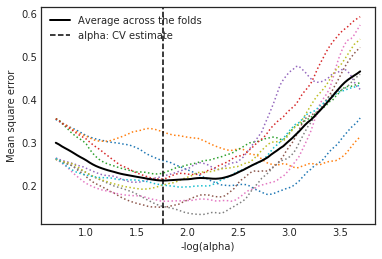

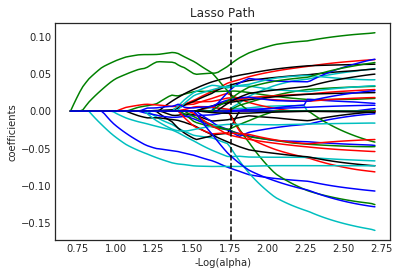

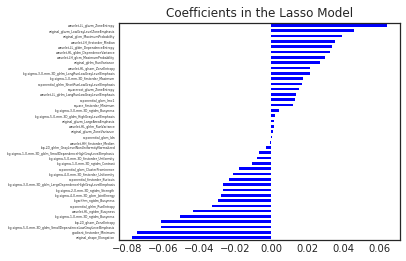

In [62]:
X_lasso,y_lasso,features_lasso = lasso_filter(X,y,10)
X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
X_test_feature.to_csv(in_path+'lasso_Test.csv')

第 1 折  matrix result:
[[23  7]
 [ 7 27]]
第 2 折  matrix result:
[[21  9]
 [ 6 28]]
第 3 折  matrix result:
[[23  7]
 [ 5 29]]
第 4 折  matrix result:
[[25  4]
 [ 9 26]]
第 5 折  matrix result:
[[24  5]
 [ 7 28]]
mean_auc=0.87 $\pm$ 0.02


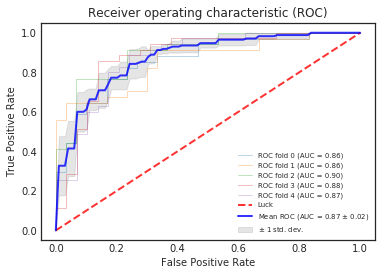

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

 95%CI: [0.83 - 0.90]
SD =  0.01977036096959976


/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

(0.8330980392156864, 0.8985300526962241)

In [63]:
model,mean_auc,y_true,y_pred = model_training(X_lasso,y_lasso,clf,5)
CI_ROC (y_true,y_pred)

## 更改clf 分类器

In [124]:
# DecisionTree
# clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=257, max_leaf_nodes=None, presort=False)
clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',random_state=100)
# clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',criterion='entropy',random_state=10)
# clf = tree.DecisionTreeClassifier(class_weight='balanced')

# RandomForest
# clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=127, verbose=0, warm_start=False, class_weight=None)
#clf = RandomForestClassifier(n_estimators=50,class_weight='balanced',criterion='entropy',random_state=5)
#clf = RandomForestClassifier(class_weight='balanced')
#clf = RandomForestClassifier(n_estimators=50)

# KNeighbors
# clf = KNeighborsClassifier(n_neighbors=6, leaf_size=30,weights='uniform',algorithm='auto',p=2)
# clf = KNeighborsClassifier(n_neighbors=6,p=2,algorithm='brute',weights ='distance')
# clf = KNeighborsClassifier(n_neighbors=4,p=2)
# clf = KNeighborsClassifier()

# MLP
#clf = MLPClassifier(hidden_layer_sizes=(4, 20))

第 1 折  matrix result:
[[18 12]
 [14 20]]
第 2 折  matrix result:
[[17 13]
 [11 23]]
第 3 折  matrix result:
[[16 14]
 [13 21]]
第 4 折  matrix result:
[[20  9]
 [14 21]]
第 5 折  matrix result:
[[20  9]
 [13 22]]
mean_auc=0.62 $\pm$ 0.03


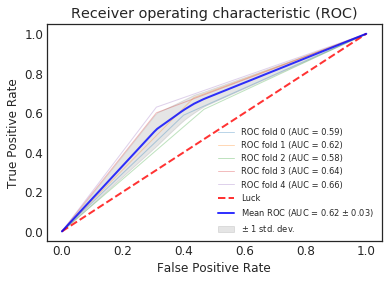

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

 95%CI: [0.57 - 0.66]
SD =  0.027045444934975158


/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 319 + 1) instead
  if __name__ == '__main__':
/home/work/anaconda3/lib/python3.6/site-

(0.5731372549019608, 0.663198247535597)

In [125]:
model,mean_auc,y_true,y_pred = model_training(X_lasso,y_lasso,clf,5)
CI_ROC (y_true,y_pred)

In [126]:
df = pd.read_csv('/home/work/moyan01/ML/浙2/Radiomic/C_yTrain_true_pred_cli.csv',index_col=0,encoding='gbk')


In [127]:
y_true=df.iloc[:,0]
y_pred=df.iloc[:,1]

In [128]:
1/1.7222222222222223

0.5806451612903225

In [129]:
matrix_report(y_true,y_pred)

[[ 91  57]
 [ 65 107]]
sensitivity =  0.6148648648648649
specificity =  0.622093023255814
precision =  0.61875


[0 1]


/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


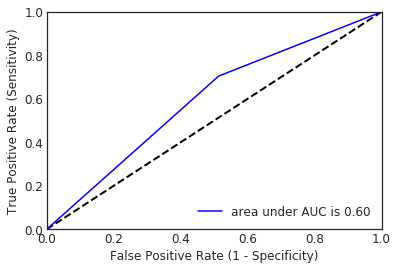

tpr-(1-fpr)指数：threshold_value =  [1.]
auc =  0.5955159705159705


In [130]:
y_test,y_pred_test,y_proba_test = model_testing(model,X_test_feature,y_test)
#CI_ROC (y_test,y_proba_test)
auc_report(y_test,y_pred_test,y_proba_test)

In [131]:
matrix_report(y_test,y_pred_test)

[[18 19]
 [13 31]]
sensitivity =  0.4864864864864865
specificity =  0.7045454545454546
precision =  0.6049382716049383


## 表格拼接

In [56]:
#df_rad= pd.read_csv('/home/work/moyan01/ML/Radiomic/lasso_Test.csv',index_col=0,encoding='gbk')
#df_cli= pd.read_csv('/home/work/moyan01/ML/Radiomic/lasso_Test.csv',index_col=0,encoding='gbk')
#df_all=pd.read_csv('/home/work/moyan01/ML/Radiomic/zunyi_shengyi_cli_rad_hefenji.csv',index_col=0,encoding='gbk')

In [57]:
in_path='/home/work/moyan01/ML/浙2/Radiomic/'  

In [58]:
list_rad=df_rad.columns.values.tolist()
list_cli=df_cli.columns.values.tolist()
list_label=['label']
list_all=list_label+list_cli

In [59]:
len(set(list_rad).difference(set(df_all.columns)))

NameError: name 'df_all' is not defined

In [123]:
df_new=df_all[list_all]
X = df_new.iloc[:,1:]#1开始计数，－2
Y = df_new.iloc[:,0] 
Y= np.array(Y, dtype = int)
ss = StandardScaler().fit(X)
X_std = ss.transform(X)
X = DataFrame(X_std,index=X.index,columns=X.columns)

In [104]:
Y

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

第 1 折  matrix result:
[[25 14]
 [ 4  8]]
第 2 折  matrix result:
[[37  2]
 [ 9  3]]
第 3 折  matrix result:
[[27 12]
 [ 5  7]]
第 4 折  matrix result:
[[24 15]
 [ 3  9]]
第 5 折  matrix result:
[[34  5]
 [ 6  6]]
mean_auc=0.71 $\pm$ 0.03


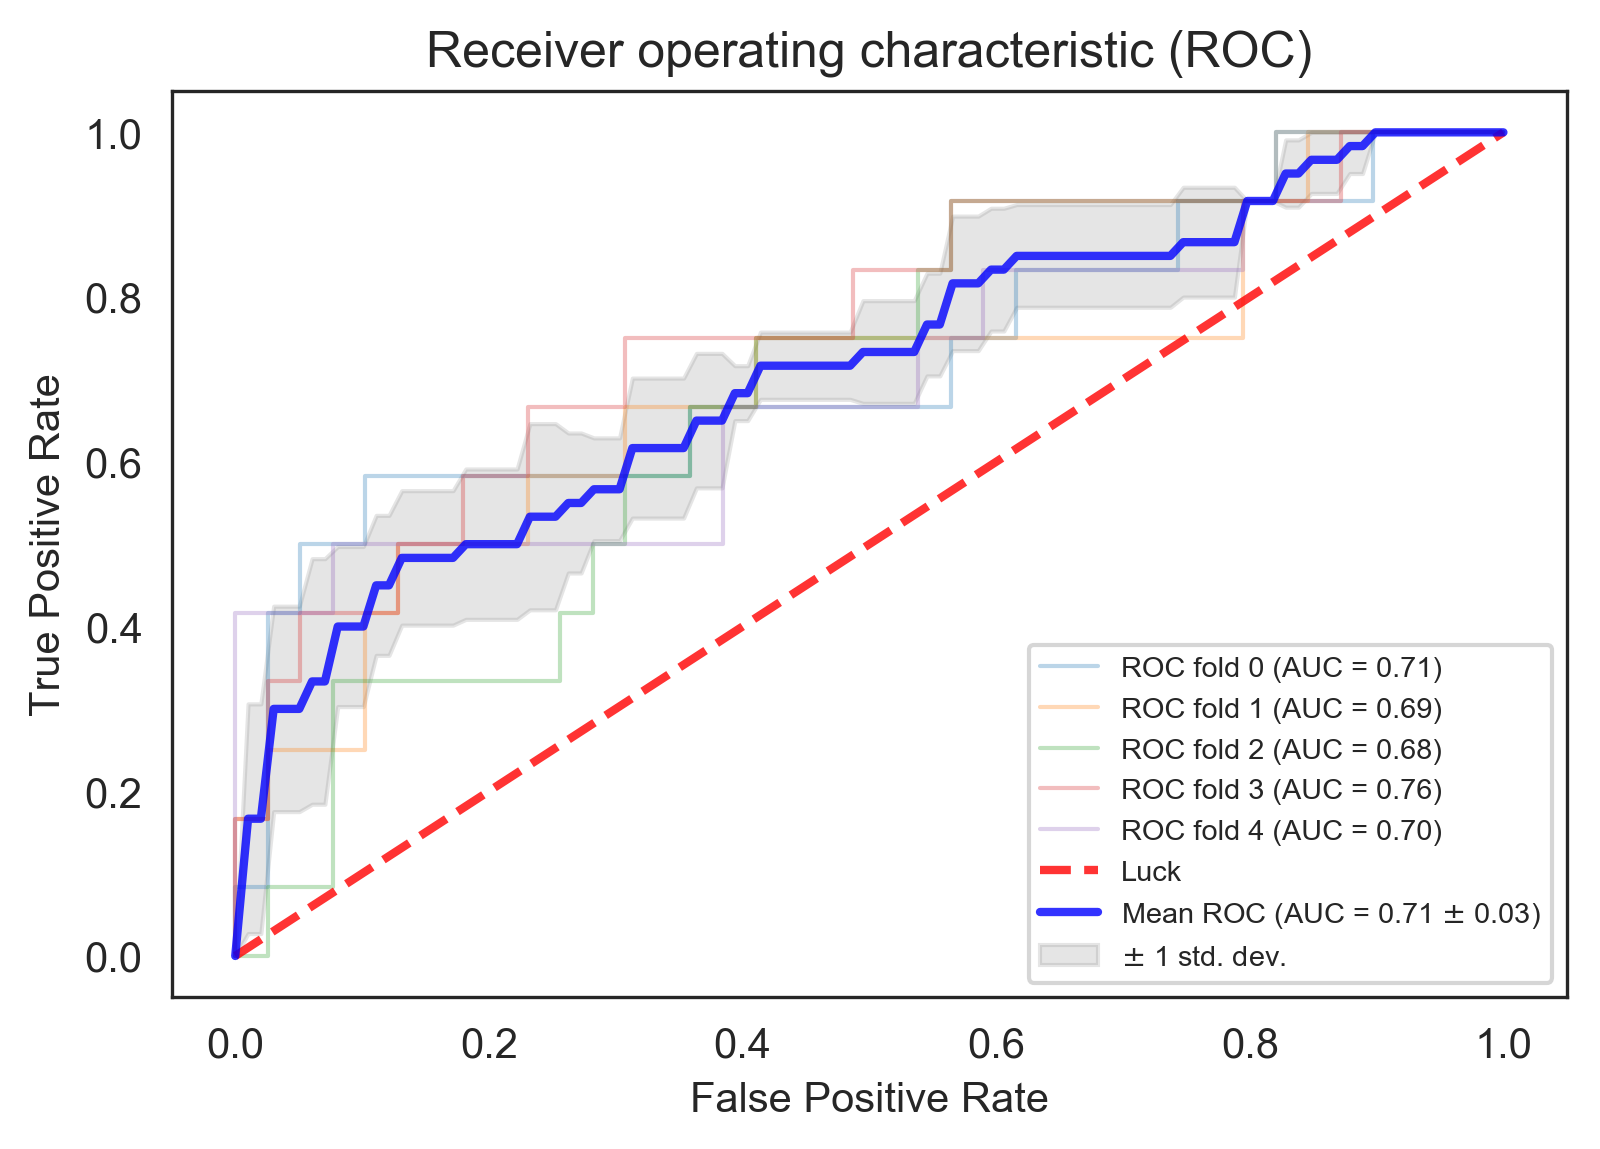

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

 95%CI: [0.63 - 0.76]
SD =  0.039874935375007595


/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

(0.6318518518518518, 0.764973544973545)

In [124]:
model,mean_auc,y_true,y_pred = model_training(X,Y,clf,5)
CI_ROC (y_true,y_pred)

In [125]:
df = pd.read_csv('/Users/hcc/Desktop/guizhoushengyi/8.28-hefenji/cli_rad/C_yTrain_true_pred_cli.csv',index_col=0,encoding='gbk')
y_true=df.iloc[:,0]
y_pred=df.iloc[:,1]
matrix_report(y_true,y_pred)

[[147  48]
 [ 27  33]]
sensitivity =  0.7538461538461538
specificity =  0.55
precision =  0.7058823529411765
